# CASE STUDY - convolutional neural networks

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import joblib
import time
from collections import Counter
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

In [2]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

Synopsis
----------

You were hired at AAVAIL to be a member of a data science team that works closely together.  Some of your first projects
are meant to help marketing with customer retention and to investigate market specific trends. There are also some
projects relating to user comments that are getting off the ground.  However, you will also be working alongside
the deep-learning specialists that maintain the core product at AAVAIL---its audio and visual manipulation models.

Because the team meets regularly all new data science hires are expected to go through a series deep-learning tutorials
to ensure that they can contribute to conversations about the core product.   The first in this series is the following
tutorial on CNNs.  You will be guided through the following parts.

  1. Environment setup
  2. Model scaffolding using Keras
  3. Logging and Model serialization
  4. Model iteration

## Fashion MNIST

>One project that the data science team at AAVAIL has been tasked with is ensuring that the video feeds are in fact news video feeds.  There are people that are performing quality assurance on these feeds, but eventually the data science team will need to build a service that samples a number of frames from a video, then identifies objects in the images, flagging for review any feeds that may be different.

A solid benchmark dataset for this task is the Fashion MNIST dataset.  

* training set - 60,000 images
* test set - 10,000 images
* images are 28 pixels x 28 pixels
* classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

## PART 1 - environment setup

In [3]:
## if you wish to work with tensorflow v1 then ask it to emulate version 2 behavior
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
print(tf.__version__)

## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.0.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2926834675352153796
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12400698852203246578
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14757470704224974849
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7057889690
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4114827783191614378
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
### load the data  
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
               'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

### QUESTION 1

Visualize a sample of the images to QA the data set (You should scroll through several pages of images) and print a summary of the data.  Also create a base model to compare your neural network to.

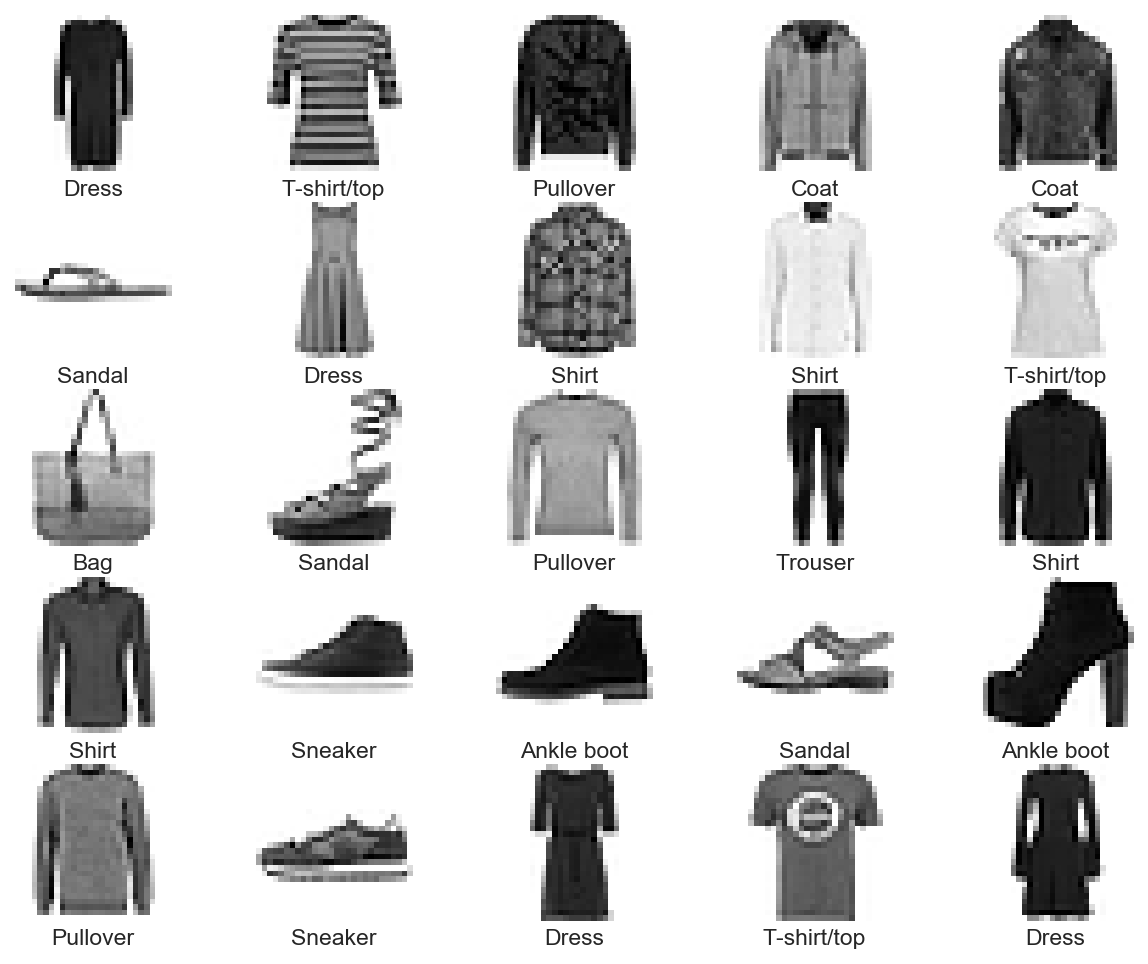

In [5]:
## YOUR CODE HERE (visualization code)

def show_img(img_ind):
    fig = plt.figure(figsize=(6,4),dpi=150,facecolor='white')
    ax = fig.add_subplot(111)

    ax.imshow(train_images[img_ind])
    ax.grid(False)
    ax.set_title(class_names[train_labels[img_ind]])
    
fig = plt.figure(figsize=(10,8),dpi=150,facecolor='white')
offset = 25
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i+offset]])

In [6]:
## YOUR CODE HERE (Summarize the data)

print("-------------------------------------------")
print("X_train: {}".format(X_train.shape))
class_info = list(sorted(Counter(y_train).items()))
print("num classes: {}, classes: {}".format(len(class_info), [i[0] for i in class_info]))
print("class samples: {}".format([i[1] for i in class_info]))
print("class balance: {}".format([round(i[1]/X_train.shape[0],2) for i in class_info]))
print(X_train.shape)
print("-------------------------------------------")

-------------------------------------------
X_train: (60000, 28, 28)
num classes: 10, classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class samples: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
class balance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
(60000, 28, 28)
-------------------------------------------


### QUESTION 2

Build a base model.  Construct a pipeline that uses PCA into a classic machine learning model.

In [7]:
## YOUR CODE HERE (base model)

X_train_flat = np.array([i.flatten() for i in train_images])
X_test_flat = np.array([i.flatten() for i in test_images])

pipe = Pipeline([('pca', PCA()),
                 ('svm', SVC(class_weight='balanced'))])

param_grid = {
    'pca__n_components': [25],
    'svm__C': [0.001,0.1,1.0,10.0],
    'svm__gamma': [0.1,0.01]
}

## grid search
if not os.path.isdir("saved"):
    os.mkdir("saved")

saved_model = os.path.join("saved",'pca-svm.joblib')
if not os.path.exists(saved_model):
    time_start = time.time()
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, iid=False, n_jobs=-1)
    grid.fit(X_train_flat, y_train)
    joblib.dump(grid, saved_model)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_model))
    grid = joblib.load(saved_model)

loading saved/pca-svm.joblib from file


In [8]:
y_pred = grid.predict(X_test_flat)
print("-->".join(pipe.named_steps.keys()))
print(classification_report(y_test, y_pred,target_names=np.array(class_names)))

pca-->svm
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.85      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.78      0.80      0.79      1000
       Dress       0.88      0.89      0.88      1000
        Coat       0.80      0.80      0.80      1000
      Sandal       0.96      0.93      0.95      1000
       Shirt       0.70      0.65      0.67      1000
     Sneaker       0.91      0.94      0.93      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.87      0.88      0.87     10000



## PART 2 -  model scaffolding using Keras

Create a function that returns a model using ``keras.models.Sequential()`` and ensure that you pass ``activation_function`` as an argument.  Instaintiate a version of the model and print the summary.  This function is just meant to return a simple multilayer perceptron network.  At a minimum the function code should contain:

```python
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
```

### QUESTION 3

Build a simple MLP

In [9]:
## YOUR CODE HERE

def build_mlp(activation_fn='relu'):
    """
    create a simple cnn
    """
    
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(128, activation=activation_fn))
    model.add(keras.layers.Dense(10, activation='softmax'))    

    return(model)

model_simple = build_mlp(activation_fn='relu')
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### QUESTION 4

Create another version of your neural network.  This time you should build a proper CNN.  Remember that one pattern to consider starting from is alternating ``Con2D`` and ``MaxPooling2D`` layers.  This is often followed by a couple of ``Dense`` layers.  Recall that the the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The output of the last ``Dense`` layer should correspond to the number of classes and generally uses a 'softmax' activation.  Use `model.summary()` to ensure a cohesive architecture.

In [10]:
## YOUR CODE HERE


def build_cnn(activation_fn='relu',dropout=None):
    """
    create a simple cnn
    """

    num_classes = np.unique(y_train).size
    
    if not dropout:
        dropout = [False,False]
    
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(28, (3, 3), activation=activation_fn, input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    
    if dropout[0]:
        model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation=activation_fn))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    
    if dropout[0]:
        model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Conv2D(64, (3, 3), activation=activation_fn))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation=activation_fn))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    

    return(model)


model = build_cnn(activation_fn='relu')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        16192     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

## PART 3 - logging and Model serialization

You can use a trained model without having to retrain it.  Your can also continue training a model to pick-up training where you left off.  The `tf.keras.callbacks.ModelCheckpoint` callback allows to continually save the model both during and at the end of training.  For long running models this is ideal in case the training is interrupted.  Otherwise you can 
used `model.save()` and `model.load()`.  In this part you will create a function that accomplished a few things at once.  Here is some pseudocode that you could work from.
```python
def train_network(model_name,model,loss_fn, optimizer='adam'):

    if not os.path.exists(saved model):
        model.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['accuracy'])
        model.fit(X_train,
                  y_train,
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test))
        
        create_log_file()
        model.save(saved_model)
    else:
        print("... loading saved model")
        model = keras.models.load_model(saved_model)
        
    return(model)    
```    
The two things you are trying to accomplish with this function are:

1. save your models so that each iteration only needs to be run once
2. save the specifics of your model in a log file 

  * optimizer 
  * loss_fn 
  * test_loss
  * test_accuracy
  * any notes

In [11]:
## YOUR CODE HERE

def train_network(model_name,model,loss_fn,X_train,y_train,X_test,y_test,optimizer='adam'):
    """
    compile, train and save the cnn
    """

    ## save model and logfile
    save_dir = 'saved'
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    saved_model = os.path.join(save_dir,"{}.h5".format(model_name))

    ## compile the model
    if not os.path.exists(saved_model):
        ## compile and fit model
        model.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['accuracy'])

        model.fit(X_train,
                  y_train,
                  batch_size=64,
                  epochs=10,
                  validation_data=(X_test, y_test))
        model.save(saved_model)

              ## evaluate model
        test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)    
        
        ## save a log file
        log_file = os.path.join(save_dir,"{}.log".format(model_name)) 
        with open(log_file, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["loss_function",loss_fn])
            writer.writerow(["optimizer", optimizer])
            writer.writerow(["test_loss",test_loss])
            writer.writerow(["test_acc",test_acc])

    else:
        print("... loading saved model")
        model = keras.models.load_model(saved_model)
                    
    return(model)       

## PART 4 - model iteration

In [12]:
## YOUR CODE HERE (build and train a MLP)
model_mlp = build_mlp(activation_fn='relu')
model_mlp = train_network("simple_mlp", model_mlp, "sparse_categorical_crossentropy",
                          X_train,
                          y_train,
                          X_test,
                          y_test,
                          optimizer='adam')

... loading saved model


In [13]:
!cat ./saved/simple_mlp.log

In [14]:
## YOUR CODE HERE (build and train a CNN)

## add the channel dimensions to your data
X_train_1 = np.expand_dims(X_train, -1)
X_test_1 = np.expand_dims(X_test, -1)

model_cnn = build_cnn(activation_fn='relu')
model_cnn = train_network("cnn", model_cnn, "sparse_categorical_crossentropy", 
                          X_train_1,
                          y_train,
                          X_test_1,
                          y_test,
                          optimizer='adam')

... loading saved model


In [15]:
!cat ./saved/cnn.log